**Introduction**
 
An auditor’s job is to search through a business’ data and search for risk factors that are associated with fraudulent behaviors. The report of the data we will use in this model is borrowed from the auditor office in India, between the years 2015 and 2016 (https://archive.ics.uci.edu/dataset/475/audit+data). The auditor assessed and calculated fraudulence risk based on audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. We are going to answer the question, “Is our new observation a fraudulent risk?” using location_ID, Inherent_Risk, and Audit_Risk as our predictors. This data set contains calculations of each risk factor, which have all been averaged into Audit_Risk.

In [65]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)

In [77]:
#Reading data into R + Wrangling/Cleaning data
audit_data <- read_csv("audit_risk.csv") |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.factor(LOCATION_ID)) |>
    mutate(Risk = fct_recode(Risk, "Suspicious" = "1", "Not Suspicious" = "0"))

audit_data <- audit_data |>
rename_at("LOCATION_ID", ~"Location_ID")

audit_data

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,Location_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,Suspicious
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,Not Suspicious
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,Not Suspicious
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,Not Suspicious
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,Not Suspicious
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,Not Suspicious


In [93]:
#Tidying Data
focused_audit_data <- audit_data |>
    select(Location_ID, Inherent_Risk, Audit_Risk, Risk) |>
    filter(Location_ID != "SAFIDON" &  Location_ID != "NUH" & Location_ID != "LOHARU")

focused_audit_data

Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
23,8.574,1.7148,Suspicious
6,2.554,0.5108,Not Suspicious
6,1.548,0.3096,Not Suspicious
⋮,⋮,⋮,⋮
14,1.456,0.2912,Not Suspicious
18,1.440,0.2880,Not Suspicious
15,1.464,0.2928,Not Suspicious


In [97]:
#creating training_set and testing_set
audit_data_split <- initial_split(focused_audit_data, prop = 0.75, strata = Risk)

audit_training <- training(audit_data_split)
audit_testing <- testing(audit_data_split)

head(audit_testing)

Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
8,1.5694,0.31388,Not Suspicious
37,50.6700,20.26800,Suspicious
37,14.4920,2.89840,Suspicious
37,2.3300,0.46600,Not Suspicious
37,71.4920,14.29840,Suspicious
3,141.7740,56.70960,Suspicious


In [98]:
#Preliminary exploratory data analysis: summarizing data to report number of observations in each class
#(suspicious vs non-suspicious) and the percentage each class of data takes up out of the whole data set
#within each location
row_number <- nrow(focused_audit_data)

location_risk <- audit_training |>
    group_by(Location_ID, Risk) |>
    summarize(count = n(),
          percentage = n()/row_number *100)

location_risk

`summarise()` has grouped output by 'Location_ID'. You can override using the
`.groups` argument.


Location_ID,Risk,count,percentage
<fct>,<fct>,<int>,<dbl>
1,Not Suspicious,2,0.2587322
1,Suspicious,7,0.9055627
11,Not Suspicious,11,1.4230272
⋮,⋮,⋮,⋮
8,Suspicious,22,2.846054
9,Not Suspicious,26,3.363519
9,Suspicious,12,1.552393


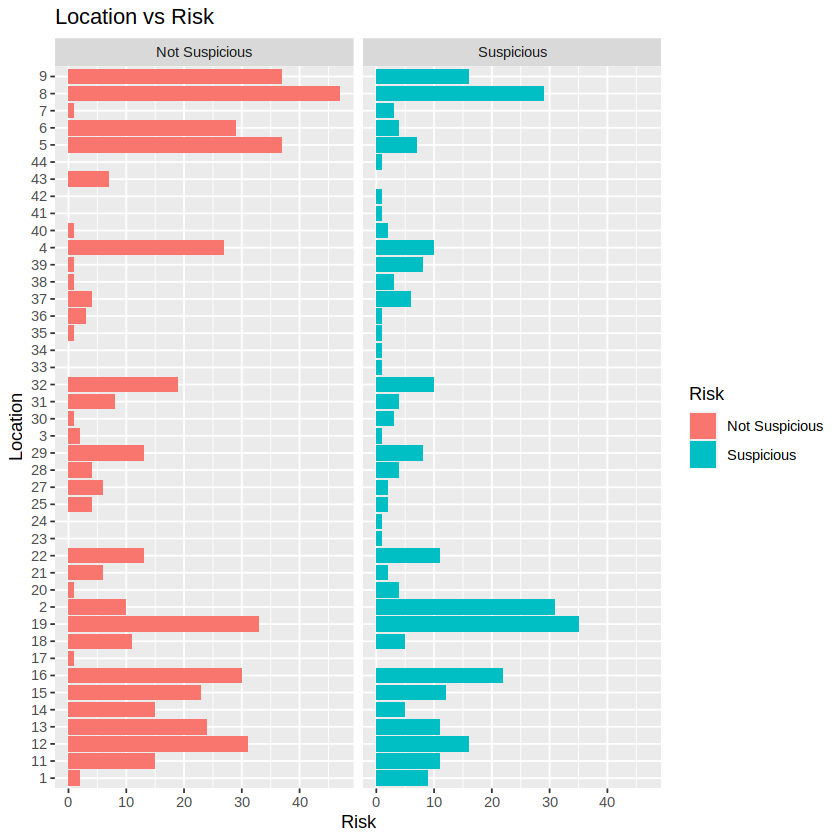

In [101]:
#Preliminary exploratory data analysis: Plotting amount of suspicious businesses and non-suspicious businesses in each
#location

location_risk_plot <- location_risk |>
    ggplot(aes(x = count, y = LOCATION_ID, fill = Risk)) +
    geom_bar(stat = "identity") +
    labs(x = "Number Of Businesses That Are A Risk", y = "Location", fill = "Risk") +
    ggtitle("Risk of Fraudulence Within Each Location") + 
    facet_grid(cols = vars(Risk))

location_vs_audit

In [99]:
#shows the relationship between classification of Risk and Inherent Risk
inherent_vs_risk <- audit_training |>
    group_by(Risk) |>
    summarize(Inherent_Risk = mean(Inherent_Risk))

inherent_vs_risk

Risk,Inherent_Risk
<fct>,<dbl>
Not Suspicious,2.001811
Suspicious,41.267579


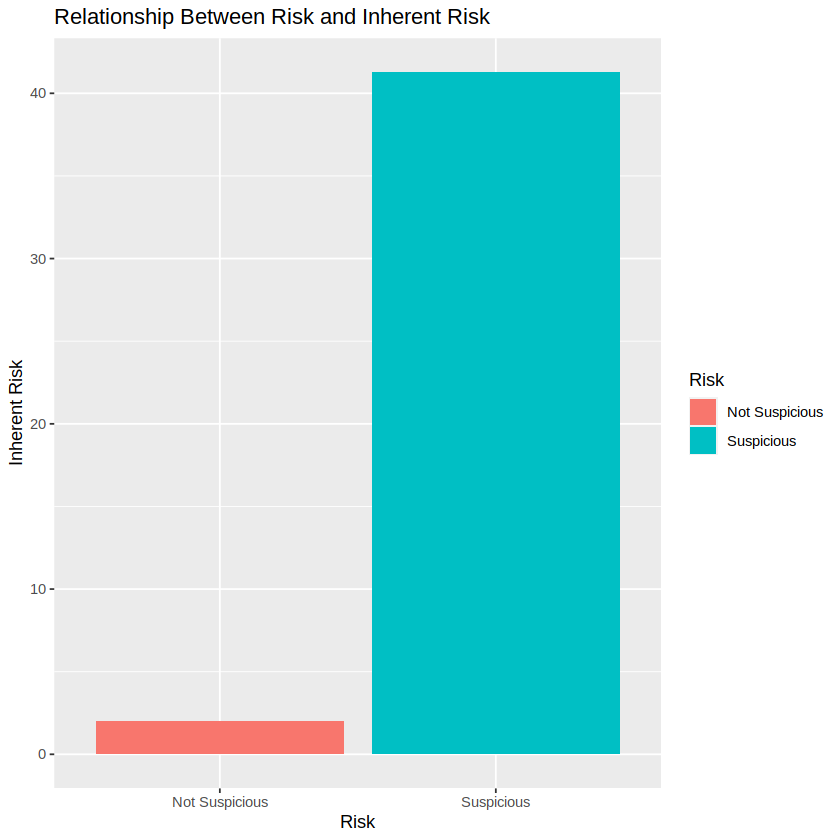

In [100]:
#visualizes the significant increase in average inherent risk in suspicious businesses compared 
#to non-suspicious businesses

inherent_vs_risk_plot <- inherent_vs_risk |>
    ggplot(aes(x = Risk, y = Inherent_Risk, fill = Risk)) +
    geom_bar(stat = "identity") +
    labs(x = "Risk", y = "Inherent Risk", fill = "Risk") +
    ggtitle("Relationship Between Risk and Inherent Risk")

inherent_vs_risk_plot

In [102]:
#Audit Risk relationship with Risk
audit_risk_vs_risk <- audit_training |>
    group_by(Risk) |>
    summarize(Audit_Risk = mean(Audit_Risk))

audit_risk_vs_risk

Risk,Audit_Risk
<fct>,<dbl>
Not Suspicious,0.4254414
Suspicious,19.1761100


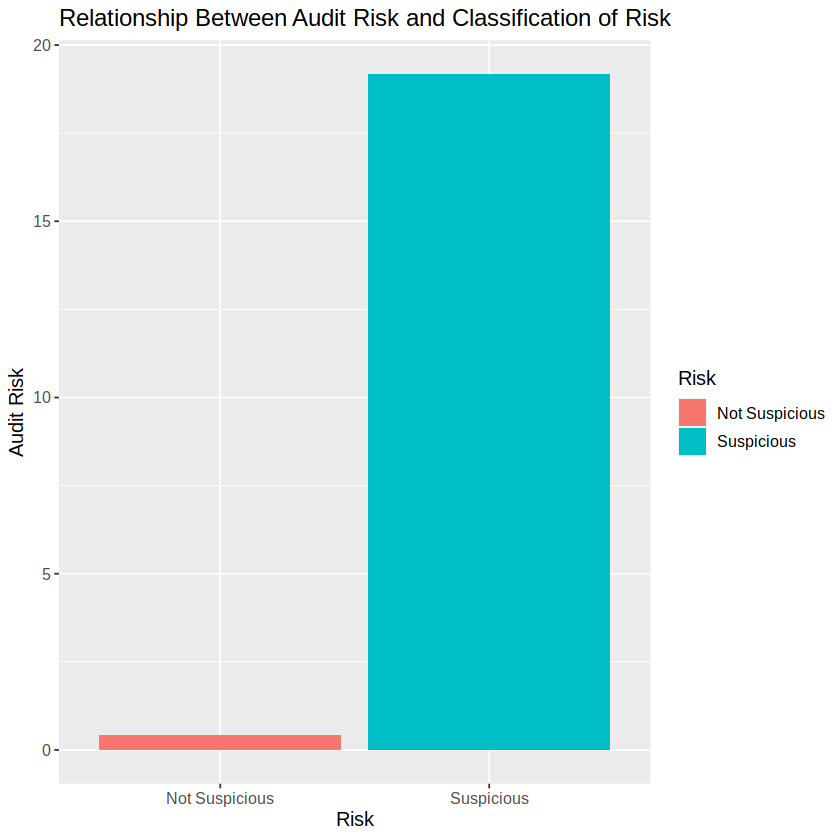

In [103]:
#Plotting audit_risk_vs_risk
audit_risk_vs_risk_plot <- audit_risk_vs_risk |>
ggplot(aes(x = Risk, y = Audit_Risk, fill = Risk)) +
geom_bar(stat = "identity") +
labs(x = "Risk", y = "Audit Risk", fill = "Risk") +
ggtitle("Relationship Between Audit Risk and Classification of Risk") +
theme(text = element_text(size = 12))

audit_risk_vs_risk_plot

**Methods**:

We will try to predict the Risk of a new observation, and we will use Location_ID, Inherent_Risk, and Audit_Risk as predictor values to predict whether our new observation is "Suspicious" or "Not Suspicious" using classification.  

1) To tidy the data, we selected the columns we will use (LOCATION_ID, Inherent_Risk, Audit_Risk, and Risk). "LOCATION_ID" column name was changed to "Location_ID" to make it more readable. We then filtered out three rows in Location_ID, “SAFIDON”, “LOHARU”, and “NUH”, as they were anomalies and do not display relevant information.

2) We identified the number of suspicious vs not suspicious risks that were associated with each Location_ID, this helped to determine the relationship between each location and the amount of suspicious activity occurring there. Plotting the information provided from this table shows a visual of which locations have the highest amount of suspicious risk.

3) Looking at the relationship between inherent risk and classified risk, we calculated the average inherent risk for all suspicious and not suspicious risks. The bar graph allows us to visualize the difference between the not-suspicious average inherent risk and the suspicious average inherent risk. 

4) Finally, we looked at the relationship between audit risk and classification of risk. This was calculated using group_by and summarize to compare the suspicious average audit risks to the not suspicious average audit risks.

We noticed that the higher the inherent and audit risk, the more likely the classified risk was suspicious. Also, Location_IDs 19, 2 and 8 show the highest amount of suspicious businesses that are fraudulent risks. These factors can now be taken into account when classifying a new observation risk.

Using mostly bar graphs, we were able to compare differences and identify trends that classify risks as either being suspicious or not suspicious. Each of our predictors showed plausible trends and significant relationships between the classified risk. Therefore, these have been validated as appropriate predictors to use in our classification model.


**Expected outcomes and significance:**

We would expect to find new observations with high audit risks and high inherent risks to be classified as suspicious. Also, if the location of our new observation is within 19, 2 (especially) or 8, we expect they would have a decent chance of being classified as suspicious. However, location is not as heavily-weighted as audit and inherent risks.


If our expectations are proven to be correct, then we could make further inferences about future observations and their classifications just based off of these three predictors alone. Identifying fraudulence would also be much more efficient if these predictors are enough to identify it.


Future Questions:

1) What is the threshold of audit and inherent risk that would result in the classification of risk being suspicious?
2) Why are certain location_IDs associated with more suspicious activity concerning fraudulence?
3) Are there other risks that influence classification of risk that were not present in this data?